In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tensorflow.keras.regularizers import l1_l2, l1, l2
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from rdkit import Chem
from mordred import Calculator, descriptors, GeometricalIndex, TopologicalIndex
from rdkit.Chem import Descriptors

2024-04-11 14:46:08.199041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path_data = Path("non_aromatic_to_train.csv")
df = pd.read_csv(path_data)
df = df.dropna(axis=1)


# Set descriptors (X) and target (y)
X = df.drop(columns = ["smiles", "mpC"])
y = df['mpC']
X.shape

(302, 503)

In [3]:
#Drop low variance features
# Calculate variance for each column
variances = X.var()

# Set a threshold for variance
threshold = 0.05  # You can adjust this threshold based on your preference

# Initialize the VarianceThreshold transformer
selector = VarianceThreshold(threshold)

# Fit the transformer to your data (finds low-variance features)
selector.fit(X)

# Get the indices of the features that are being kept
kept_indices = selector.get_support(indices=True)

# Filter the original DataFrame to keep only the high-variance columns
X = X.iloc[:, kept_indices]
X.shape

(302, 480)

In [4]:
#Drop higly correlated features
# Calculate the correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X = X.drop(to_drop, axis=1)
X.shape

(302, 91)

In [5]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2)

# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# reset the index 

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [6]:
#Initiate the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=16)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8108.5078 - mae: 78.3597 - val_loss: 6896.0181 - val_mae: 73.9341
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7090.1416 - mae: 70.5474 - val_loss: 6748.1636 - val_mae: 72.9128
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7609.6333 - mae: 75.0097 - val_loss: 6413.3618 - val_mae: 70.6382
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6898.0542 - mae: 69.5272 - val_loss: 5643.6978 - val_mae: 65.6231
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4863.5000 - mae: 57.2610 - val_loss: 4357.8369 - val_mae: 56.4515
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3523.3374 - mae: 48.6115 - val_loss: 3293.9180 - val_mae: 42.3953
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2374.9253 - mae: 36.2997 - val_loss: 2987.1633 - val_mae: 38.4197
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1620.6438 - mae: 27.8287 - val_loss: 2706.5320 - val_mae: 35.54

In [8]:
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {test_mae}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1090.3851 - mae: 20.4147 
Test MAE: 18.86341667175293


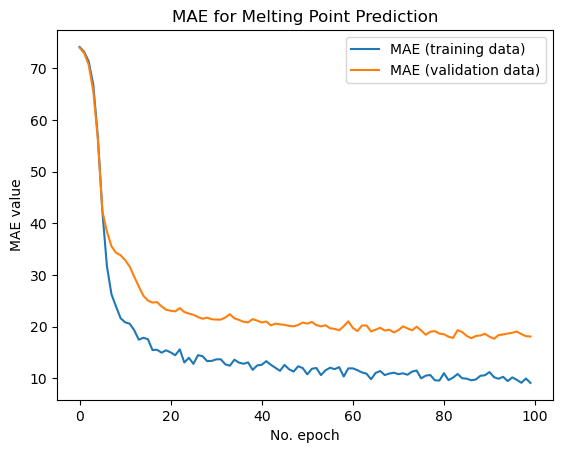

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['val_mae'], label='MAE (validation data)')
plt.title('MAE for Melting Point Prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
MSE: 931.4686650722165
R^2 score: 0.8472010452499297


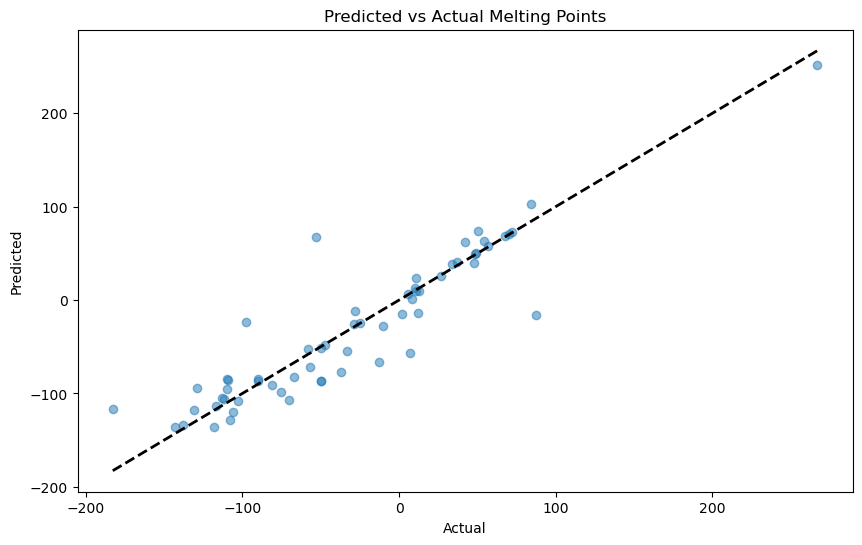

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test_scaled)

# Calculating MSE and R^2
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MSE: {mse}")
print(f"R^2 score: {r2}")

# Plotting Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Melting Points')
plt.show()


### Try with Dropout :

In [11]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# reset the index 

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

model = Sequential([
    Dense(64, activation='relu', input_shape=(91,), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=5, min_lr=0.0001)


model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7287.3237 - mae: 71.5992 - val_loss: 8384.8750 - val_mae: 76.8274 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6577.7573 - mae: 67.4850 - val_loss: 8251.0381 - val_mae: 76.0423 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6666.1196 - mae: 69.4619 - val_loss: 8087.2026 - val_mae: 75.0406 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6865.2651 - mae: 69.9830 - val_loss: 7835.8823 - val_mae: 73.5606 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6249.6616 - mae: 65.7071 - val_loss: 7455.3442 - val_mae: 71.3951 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5941.0034 - mae: 64.5211 - val_loss: 6928.3696 - val_mae: 68.3992 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5272.0654 - mae: 60.0274 - val_loss: 6265.9121 - val_mae

In [12]:
# Evaluate on validation data
val_loss, val_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Validation MAE: {val_mae}')

Validation MAE: 19.793338775634766


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE: 1103.3001298832148
R^2 score: 0.8319270741653786


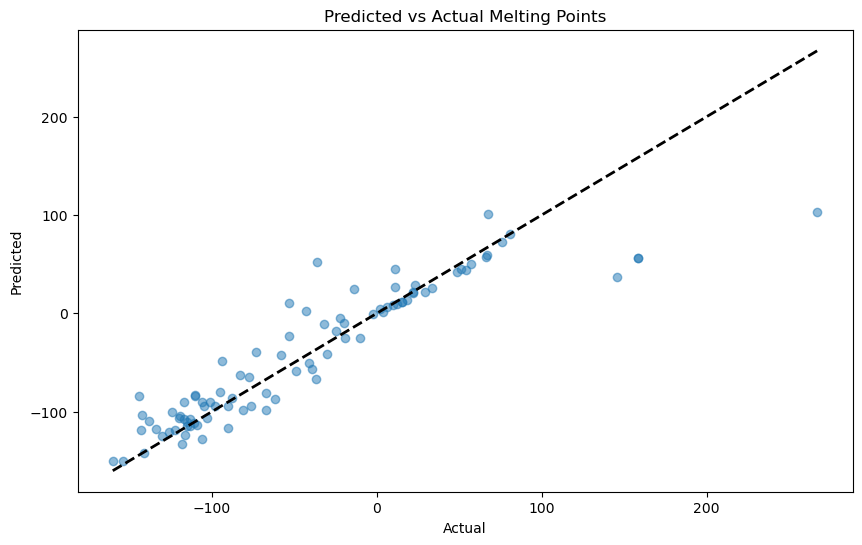

In [13]:
# Predict on validation data
predictions = model.predict(X_test_scaled)

# Assuming `X_test_scaled` is your scaled test set and `y_test` are the true melting point values
predictions = model.predict(X_test_scaled)

# Calculating MSE and R^2
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MSE: {mse}")
print(f"R^2 score: {r2}")

# Plotting Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Melting Points')
plt.show()

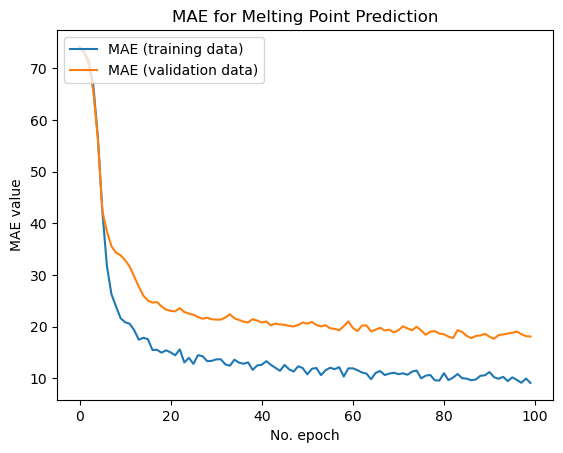

In [14]:
plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['val_mae'], label='MAE (validation data)')
plt.title('MAE for Melting Point Prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Try with k-fold cross validation

Training on fold 1/5...


/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Training on fold 2/5...


/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Training on fold 3/5...


/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Training on fold 4/5...


/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Training on fold 5/5...


/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


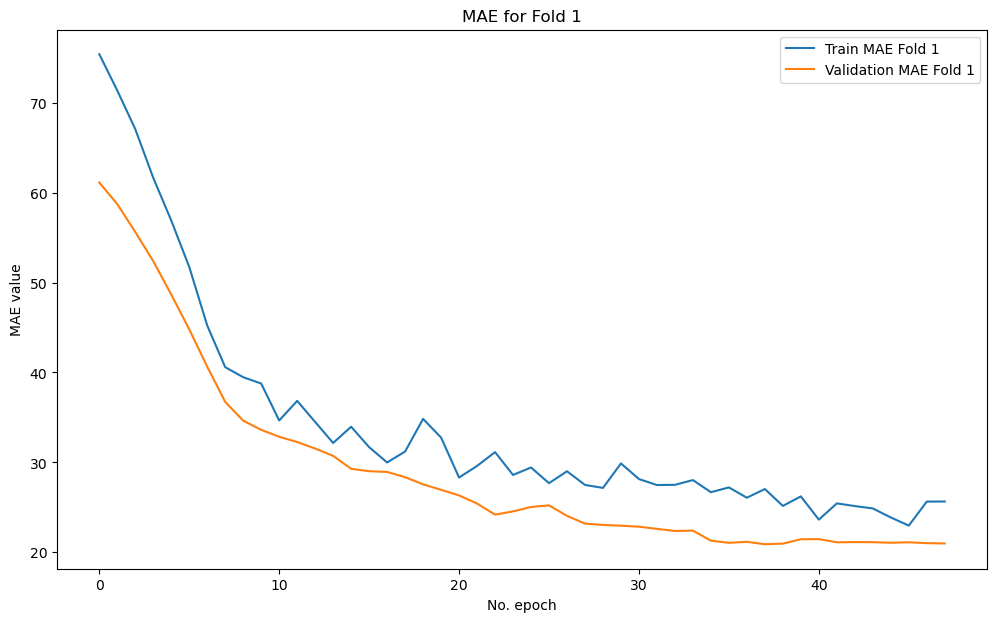

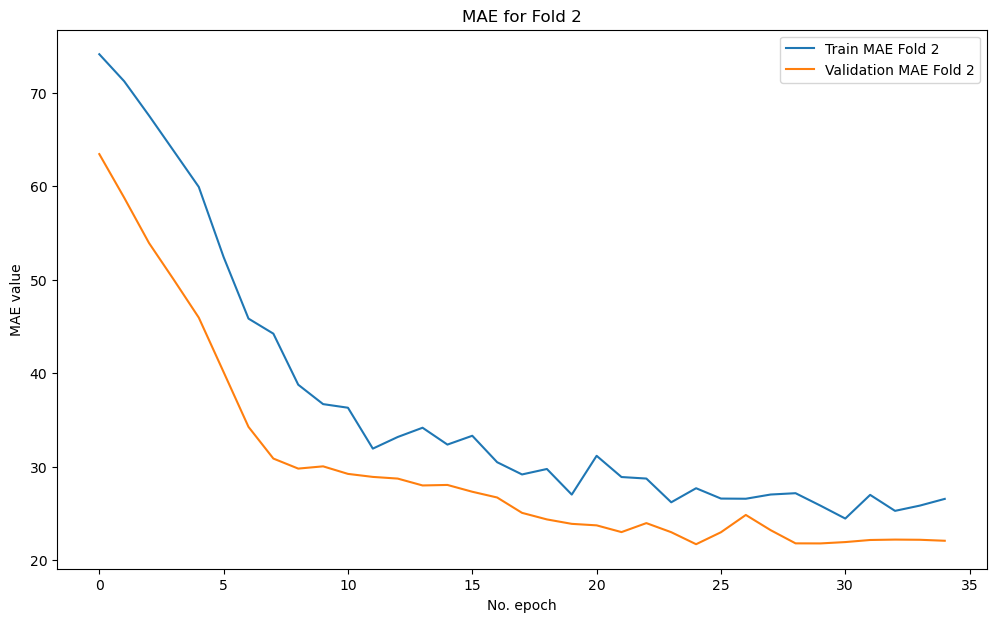

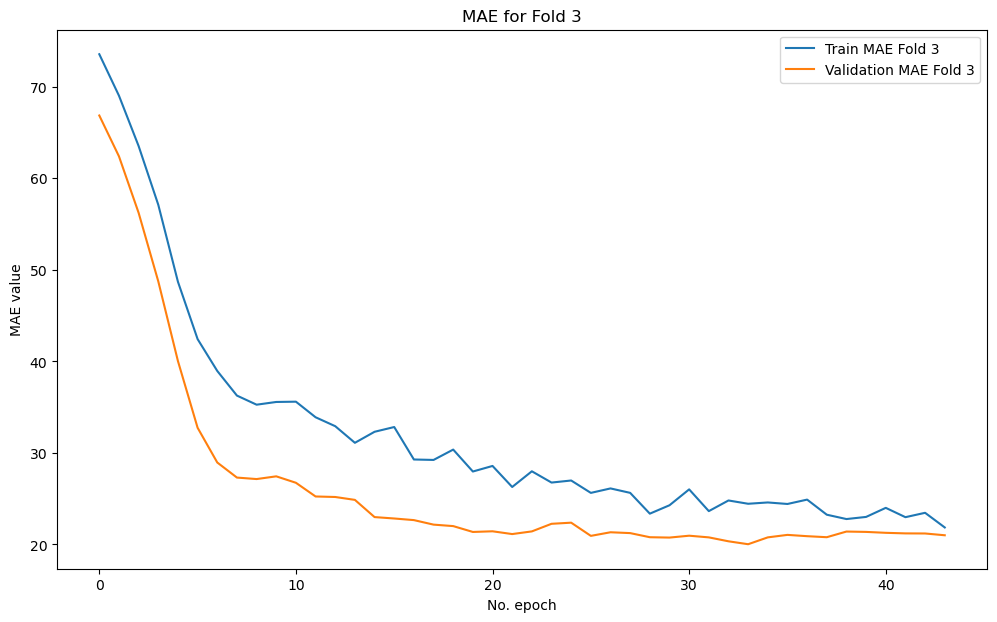

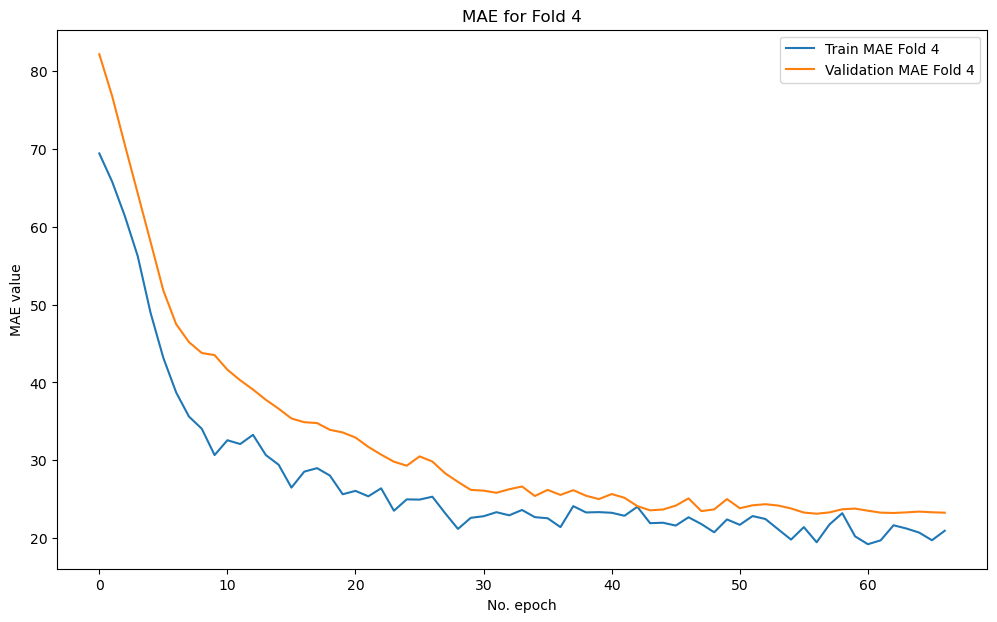

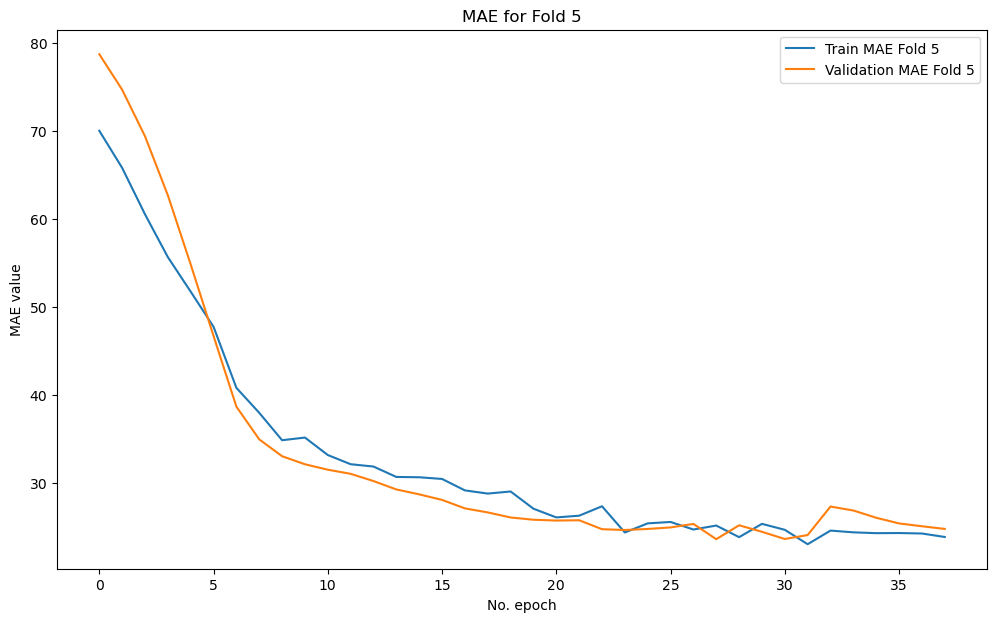

MSE: 789.2109831966802
R^2 score: 0.8098562487058492


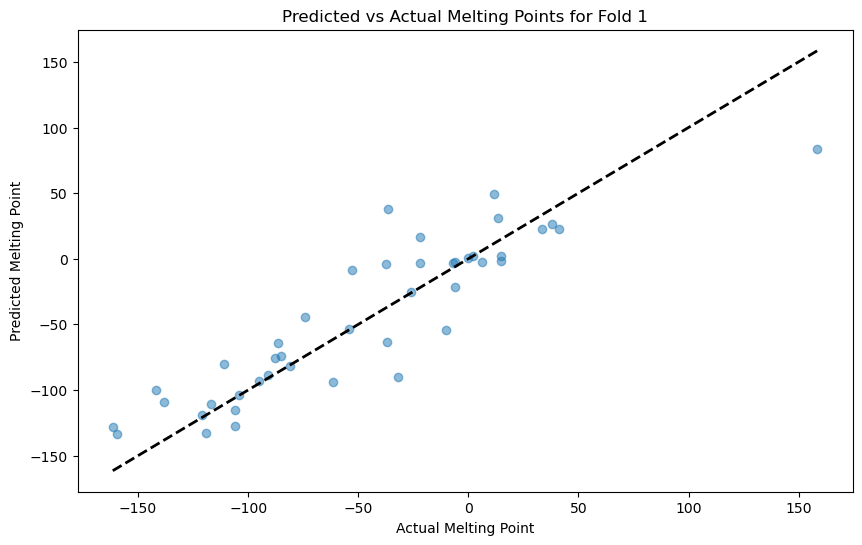

MSE: 1041.8931318489501
R^2 score: 0.7711194864895747


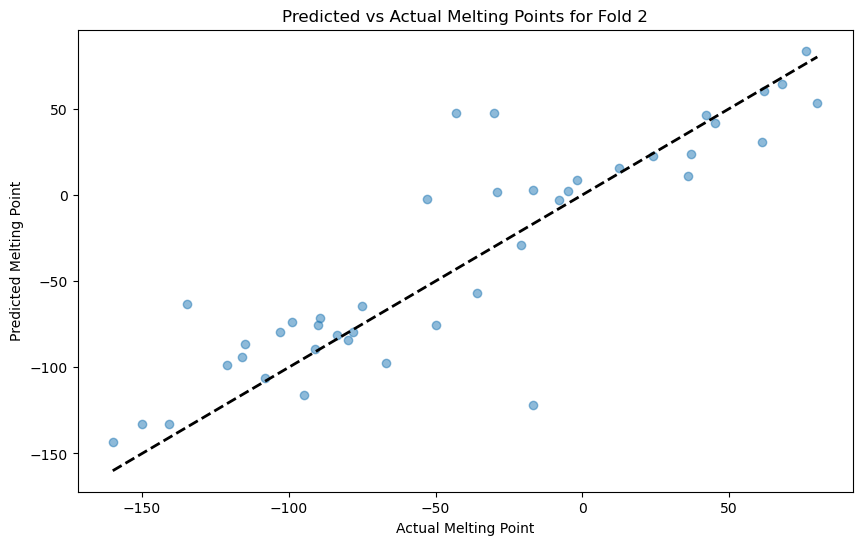

MSE: 637.864310928419
R^2 score: 0.837390071316549


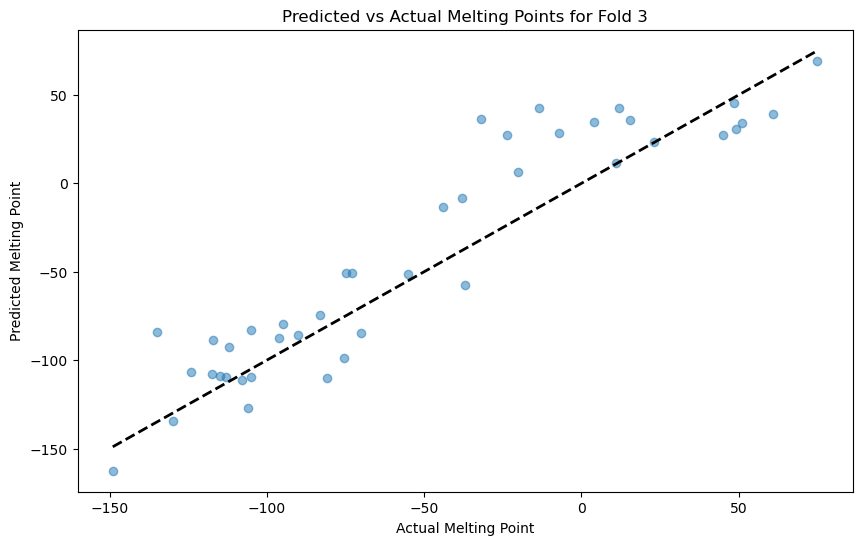

MSE: 1984.371307671932
R^2 score: 0.7675864004824806


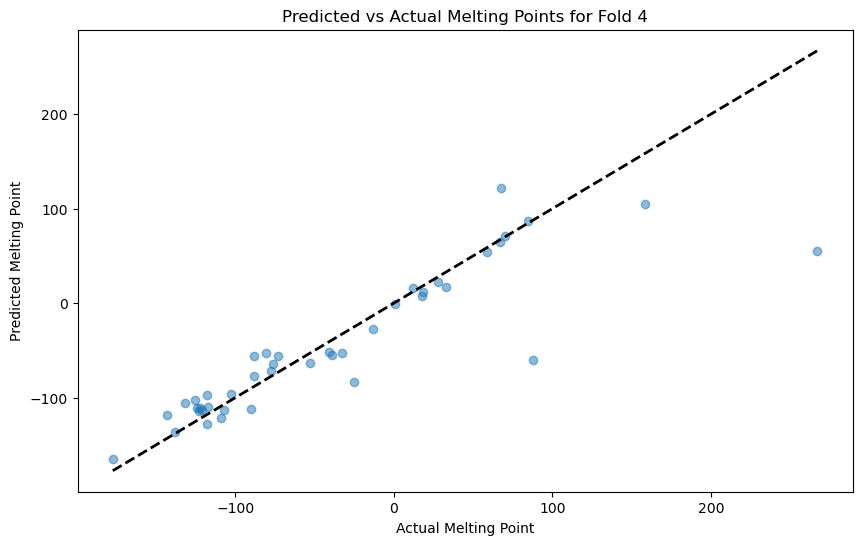

MSE: 1231.9606429447322
R^2 score: 0.8085593125133947


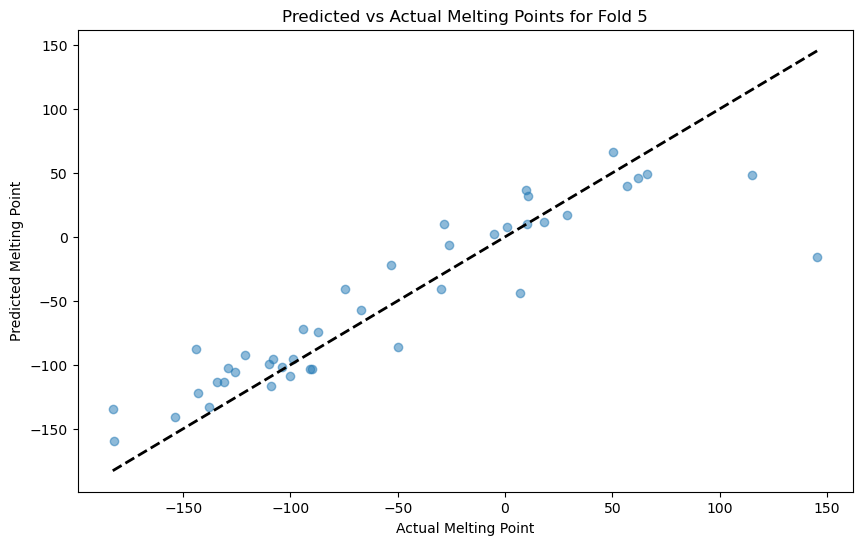

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2)

# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# reset the index 

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Prepare lists to store results for plotting
fold_predictions = []
histories = []

# K-Fold Cross-validation
kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_scaled, y_train)):
    print(f"Training on fold {fold+1}/5...")
    # Split the data
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Build the model
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(1)
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    
    # Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=5, min_lr=0.0001)
    
    # Fit the model
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=100,
        batch_size=16,
        callbacks=[early_stopping, reduce_lr],
        verbose=0  # Set verbose to 1 if you want to see the training progress for each fold
    )
    
    # Save the history
    histories.append(history)
    
    # Generate fold's predictions
    fold_pred = model.predict(X_val_fold).flatten()
    fold_predictions.append((y_val_fold, fold_pred))

# Plotting the learning curves
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 7))
    plt.plot(history.history['mae'], label=f'Train MAE Fold {i+1}')
    plt.plot(history.history['val_mae'], label=f'Validation MAE Fold {i+1}')
    plt.title(f'MAE for Fold {i+1}')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend()
    plt.show()

# Plotting predicted vs actual for each fold
for i, (actual, predicted) in enumerate(fold_predictions):

    # Calculating MSE and R^2
    mse = mean_squared_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"MSE: {mse}")
    print(f"R^2 score: {r2}")

    # Plotting Predicted vs. Actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
    plt.title(f'Predicted vs Actual Melting Points for Fold {i+1}')
    plt.xlabel('Actual Melting Point')
    plt.ylabel('Predicted Melting Point')
    plt.show()


## Save the model

In [179]:
# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = scaler.transform(X)



# Retrain the model on the entire training dataset
final_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_scaled.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Assuming early_stopping and reduce_lr callbacks are already defined as before
final_model.fit(
    X_scaled, y,
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1  # or 0 if you don't want the training log
)

# Save the model
final_model.save('melting_point_model.h5')

Epoch 1/100


/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6830.4502 - mae: 69.1835 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5802.0713 - mae: 63.1044 - learning_rate: 0.0010
Epoch 3/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6128.9468 - mae: 70.3115

/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_mae` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)
/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_mae` which is not available. Available metrics are: loss,mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4296.9478 - mae: 54.0819 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3426.2515 - mae: 45.0498 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2416.0659 - mae: 37.2268 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2271.0073 - mae: 35.1230 - learning_rate: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2171.3015 - mae: 34.8998 - learning_rate: 0.0010
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1974.6410 - mae: 33.5015 - learning_rate: 0.0010
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1928.9862 - mae: 31.5027 - learning_rate: 0.0010
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1951.2938 - mae: 31.2333 - learning_rate: 0.0010
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1662.9105 - mae: 28.5528 - learning_rate: 0.0010
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━

In [180]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('melting_point_model.h5')

predicitions = loaded_model.predict(X_scaled)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


MSE: 244.16515500553768
R^2 score: 0.9443257148827107


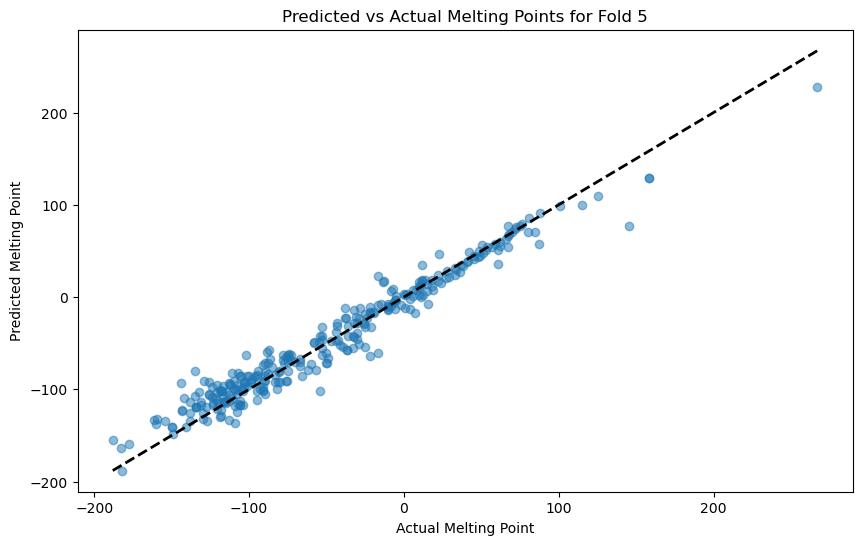

In [181]:
# Calculating MSE and R^2
mse = mean_squared_error(predicitions, y)
r2 = r2_score(predicitions, y)

print(f"MSE: {mse}")
print(f"R^2 score: {r2}")

# Plotting Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, predicitions, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title(f'Predicted vs Actual Melting Points for Fold {i+1}')
plt.xlabel('Actual Melting Point')
plt.ylabel('Predicted Melting Point')
plt.show()

In [183]:
# Save the model
final_model.save('melting_point_model.keras')

# Valider les données

In [4]:
train_smiles = pd.read_csv("non_aromatic_to_train.csv")
validation_data = pd.read_excel("/Users/malogfeller/git/Ppchem-MP-predictor/Data/second_raw_data.xlsx")
validation_data.shape


(2706, 8)

In [5]:
# Define a function to check if a SMILES contains only carbon
def contains_carbon(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetSymbol() != "C":
                return False
        return True
    except:
        return False


In [6]:


# Add a new column with the result of applying the function to the "smiles" column
validation_data['contains_only_carbon'] = validation_data['SMILES'].apply(lambda x: contains_carbon(x))

[09:52:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[09:52:04] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[09:52:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[09:52:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[09:52:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


In [7]:

carbon_validation_data = validation_data[validation_data['contains_only_carbon'] == True]
#reset the index
carbon_validation_data.reset_index(drop=True, inplace=True)
carbon_validation_data

,#,CSID,Low °C,High °C,Ave °C,SMILES,name,range,contains_only_carbon
0,2,11232,-161.51,-161.5,-161.505000,C1(CCC1)C,methylcyclobutane,0.01,True
1,2,6086,-80.80,-80.7,-80.750000,C#C,acetylene,0.10,True
2,2,21998,-115.10,-115.0,-115.050000,C/C(C)=C(/C)CCC,"2,3-dimethyl-2-hexene",0.10,True
3,2,11179,-110.00,-109.9,-109.950000,C=C(C)C(C)(C)C,"2,3,3-trimethyl-1-butene",0.10,True
4,2,15794,-124.10,-124.0,-124.050000,C=C(C)CC(C)C,"2,4-dimethyl-1-pentene",0.10,True
...,...,...,...,...,...,...,...,...,...
277,2,62633,22.50,27.0,24.750000,CCCCCCCCCCCCCCCCC#C,1-octadecyne,4.50,True
278,5,8788,273.50,278.0,276.104000,c1cc2cccc3c2c(c1)c4cccc5c4c3ccc5,perylene,4.50,True
279,7,6592,112.00,116.5,114.897143,c1ccc-2c(c1)Cc3c2cccc3,fluorene,4.50,True
280,3,14430,246.00,251.0,248.670000,c1ccc(cc1)c2c3ccccc3c(c4c2cccc4)c5ccccc5,"9,10-diphenylanthracene",5.00,True


In [8]:
import pandas as pd


carbon_validation_data['SMILES'] = carbon_validation_data['SMILES'].str.upper()  
train_smiles['smiles'] = train_smiles['smiles'].str.upper()  


smiles_set = set(train_smiles['smiles'])

# Use the isin method combined with the negation (~) to filter out rows
validation_data_filtered = carbon_validation_data[~carbon_validation_data['SMILES'].isin(smiles_set)]



/var/folders/qy/8nbc5kyd0fd_60v_krw9dwf40000gp/T/ipykernel_1980/1077042508.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_validation_data['SMILES'] = carbon_validation_data['SMILES'].str.upper()


In [9]:
validation = validation_data_filtered[["SMILES", "Ave °C"]]
validation.reset_index(drop=True, inplace=True)

In [158]:
# Function to calculate all Mordred descriptors for a given SMILES string
def calculate_all_mordred_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    calc = Calculator(descriptors)
    mordred_descriptors = calc(mol)
    return mordred_descriptors.fill_missing().asdict()

# List to store dictionaries of descriptors for each molecule
descriptor_dicts = []

# Iterate over each SMILES string and calculate descriptors
for smiles in validation['SMILES']:
    descriptor_dict = calculate_all_mordred_descriptors(smiles)
    descriptor_dicts.append(descriptor_dict)

# Convert the list of dictionaries into a DataFrame
validation_descriptors = pd.DataFrame(descriptor_dicts)

KeyboardInterrupt: 

In [3]:
"""
# Save as csv validation_descriptors
validation_descriptors.to_csv("validation_descriptors.csv", index=False)
validation_descriptors.shape
"""
validation_descriptors = pd.read_csv("validation_descriptors.csv")

In [10]:
""""
# Reset the indices of df and df_descriptors
validation.reset_index(drop=True, inplace=True)
validation_descriptors.reset_index(drop=True, inplace=True)

# Concatenate df and df_descriptors along the columns axis (axis=1)
df_combined = pd.concat([validation, validation_descriptors], axis=1)
""""

df_combined.to_csv('full_validation.csv', index=False)

In [13]:
df_combined = pd.read_csv('full_validation.csv')

,SMILES,Ave °C,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,C1(CCC1)C,-161.505000,NaN,NaN,0,0,5.595865,2.135779,4.271558,5.595865,...,8.281724,31.458132,70.078250,4.671883,16,1,22.0,23.0,1.861111,1.166667
1,C/C(C)=C(/C)CCC,-115.050000,NaN,NaN,0,0,8.647053,2.074313,4.148627,8.647053,...,8.011355,34.323564,112.125201,4.671883,70,7,30.0,30.0,4.722222,2.027778
2,C=C(C)C(C)(C)C,-109.950000,NaN,NaN,0,0,6.602720,2.175328,4.350655,6.602720,...,8.466531,34.219913,98.109550,4.671883,42,6,30.0,30.0,5.173611,1.500000
3,C=C(C)CC(C)C,-124.050000,NaN,NaN,0,0,6.828427,2.000000,4.000000,6.828427,...,7.655864,32.211905,98.109550,4.671883,48,4,26.0,24.0,4.472222,1.666667
4,CC=1CCCCC=1C,-84.050000,NaN,NaN,0,0,9.953960,2.193527,4.387054,9.953960,...,8.555837,35.908899,110.109550,5.004980,60,8,36.0,39.0,3.222222,1.861111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,CC1CCCC(C1)C=C,-84.770000,NaN,NaN,0,0,11.142106,2.200122,4.400244,11.142106,...,8.606851,37.313444,124.125201,4.965008,88,9,40.0,43.0,3.472222,2.166667
148,C1CC2CCCC3C2C(C1)C4CCCC5C4C3CCC5,276.104000,NaN,NaN,0,0,28.245314,2.588364,5.176728,28.245314,...,10.414783,55.065992,272.250401,5.235585,654,41,120.0,152.0,3.888889,4.222222
149,C1CCC-2C(C1)CC3C2CCCC3,114.897143,NaN,NaN,0,0,17.905890,2.468694,4.747108,17.905890,...,9.601774,59.273430,178.172151,5.090633,219,19,72.0,87.0,2.694444,2.833333
150,C1CCC(CC1)C2C3CCCCC3C(C4C2CCCC4)C5CCCCC5,248.670000,NaN,NaN,0,0,36.170988,2.561553,5.123106,36.170988,...,10.414543,61.629162,356.344301,5.090633,1437,47,144.0,176.0,5.388889,5.722222


In [186]:
# Function to count the number of carbon atoms in a molecule
def count_carbon(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    carbon_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6)
    return carbon_count

# Add a new column 'carbon_count' to the DataFrame
df_combined['carbon_count'] = df_combined['SMILES'].apply(count_carbon)


In [187]:
y_validation = df_combined['Ave °C']
X_validation = df_combined.drop(columns=['SMILES', 'Ave °C'])
X_validation.dropna(axis=1, inplace=True)

# Keep only column of X_validation that are also in X_train
X_validation = X_validation[X.columns]

#Scale the data
X_validation_scaled = scaler.transform(X_validation)

print(X_validation.shape)
print(X_scaled.shape)



(152, 503)
(302, 503)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 4685.884851129974
R^2 score: 0.6613261960353034


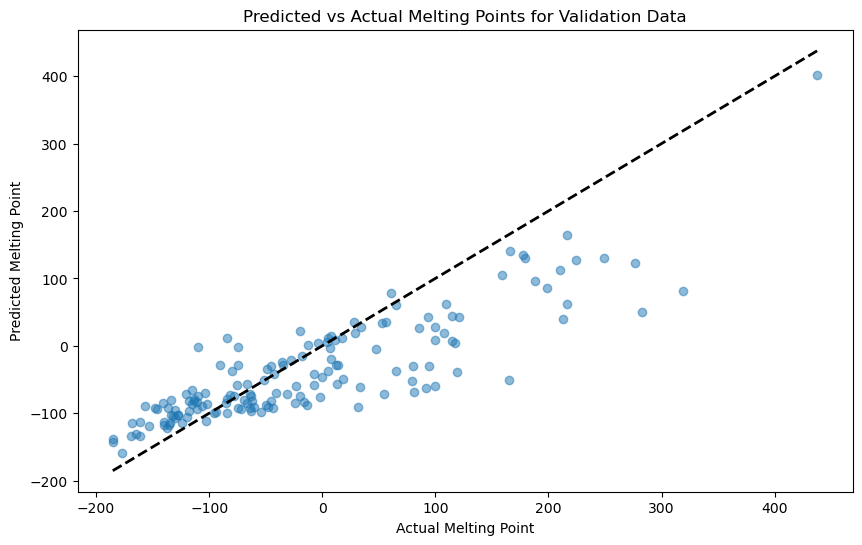

In [188]:
# Make predictions on the validation data
validation_predictions = loaded_model.predict(X_validation_scaled)

# Calculate MSE and R^2
mse = mean_squared_error(y_validation, validation_predictions)
r2 = r2_score(y_validation, validation_predictions)

print(f"MSE: {mse}")

print(f"R^2 score: {r2}")

# Plotting Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_validation, validation_predictions, alpha=0.5)
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'k--', lw=2)
plt.title('Predicted vs Actual Melting Points for Validation Data')
plt.xlabel('Actual Melting Point')
plt.ylabel('Predicted Melting Point')
plt.show()

